## PROJEKT 1 - Modelowanie Układów Przepływowych 2025/26 dla Fizyki Technicznej AGH



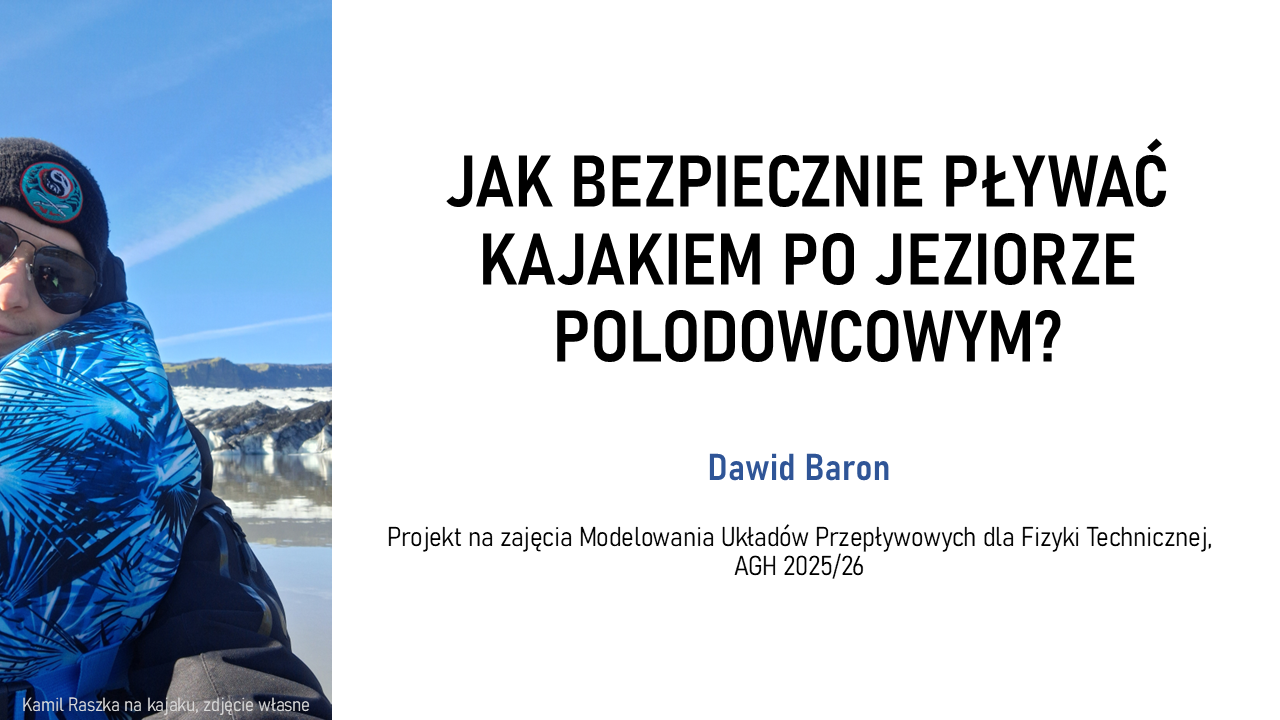

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [ ]:
import os
os.environ["NUMBA_THREADING_LAYER"] = 'omp'

### 0. Import niezbędnych pakietów Pythona

In [ ]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

### 1. Opis rozwiązywanego problemu

Podczas wyjazdu na Islandię z *SKNF Bozon*, prowadząc pomiary w rejonie jezior polodowcowych, zmuszeni byliśmy do wykorzystywania kajaka jako głównego środka transportu po akwenie. W cieplejsze dni obserwowaliśmy, jak fragmenty lodowca odrywają się od jego czoła i wpadają do wody, wywołując wyraźne zaburzenia poziomu zwierciadła jeziora oraz propagację fal w jego obrębie.

Celem niniejszego projektu jest numeryczna symulacja zaburzenia wody powstałego w wyniku wpadnięcia do jeziora kawałka lodowca oraz próba odpowiedzi na pytanie, w jaki sposób najlepiej ustawić się kajakiem względem powstającej fali, aby zminimalizować ryzyko wywrócenia jednostki pływającej.

W projekcie przyjęto następujące założenia:

*   Dno jeziora jest przybliżone **jako dolina u-kształtna** i opisane funkcją sinusoidalną wzdłuż jednej z osi poziomych.
*   Kajak znajduje się w pozycji optymalnej względem nadchodzącej fali wtedy, gdy jest ustawiony prostopadle do frontu fali, co odpowiada ustawieniu **równoległemu do wektora prędkości** jej propagacji w danym punkcie.
*   Najbezpieczniejsze do pływania są miejsca z **jak najmniejszą prędkością** propagacji fali
*   Wpadający do wody odłamek lodowca pozostawia po sobie zaburzenie poziomu wody o geometrii falki "mexican hat", o równaniu
*   Fragment lodowca wpada do jeziora w miejscu, gdzie jego głębokość jest największa

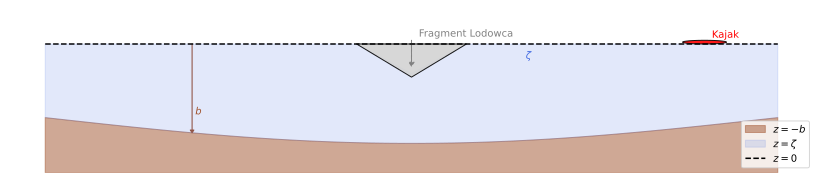

In [ ]:
pyplot.figure(figsize=(14.5, 3))
pyplot.axis('off')

x = np.linspace(0, 10, 400)

b0 = -2.0
amp_b = 0.7
b = b0 - amp_b * np.sin(np.pi * x / x.max())

zeta = np.zeros_like(x)


x0    = (x[0] + x[-1]) / 2
width = 1.5
amp_z = 0.8

mask = np.abs(x - x0) <= width / 2
zeta[mask] = -amp_z * (1 - np.abs(x[mask] - x0) / (width / 2))

arrow_kwargs = {'length_includes_head': True, 'head_width': .05}

color = 'sienna'
pyplot.fill_between(
    x, b, b.min() - 0.8,
    color=color,
    label=r'$z=-b$',
    alpha=.5
)
ix = 80
pyplot.arrow(x[ix], 0, 0, b[ix], color=color, **arrow_kwargs)
pyplot.annotate(" $b$", xy=(x[ix], b[ix] + 0.5), color=color)


color = 'royalblue'
pyplot.fill_between(
    x, zeta, b,
    color=color,
    alpha=.15,
    label=r'$z=\zeta$'
)
ix = 260
pyplot.arrow(x[ix], 0, 0, zeta[ix], color=color, **arrow_kwargs)
pyplot.annotate(r" $\zeta$", xy=(x[ix], zeta[ix] - 0.4), color=color)


color = 'black'
pyplot.plot(x, np.zeros_like(x), linestyle='--', color=color, label=r'$z=0$')


ice_x = [x0 - width/2, x0 + width/2, x0]
ice_z = [0.0, 0.0, -0.9]
pyplot.fill(ice_x, ice_z, color='lightgray', edgecolor='k', alpha=0.9)
pyplot.annotate("Fragment Lodowca", xy=(x0 + 0.1, 0.2), color='gray')


pyplot.arrow(
    x0, 0.1,
    0, -0.7,
    color='gray',
    linestyle='--',
    length_includes_head=True,
    head_width=0.07
)


kayak_center = x[-1] - 1.0
z_kayak_center = 0.05

kayak_len = 0.6
kayak_width = 0.10


theta = np.linspace(0, 2*np.pi, 100)
kayak_x = kayak_center + (kayak_len / 2) * np.cos(theta)
kayak_z = z_kayak_center + (kayak_width / 2) * np.sin(theta)

pyplot.fill(kayak_x, kayak_z, color='red', edgecolor='k', alpha=0.9)
pyplot.annotate("Kajak", xy=(kayak_center + 0.1, z_kayak_center + 0.12),
                color='red')


pyplot.ylim(b.min() - 0.8, 1.0)

pyplot.legend(loc='lower right')

show_plot('sin_bottom_glacier')


### 2. Solwer równań płytkiej wody zbudowany na bazie PyMPDATA (autor - dr Sylwester Arabas)

In [ ]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, bathymetry: np.ndarray, h_initial: np.ndarray, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }
        self.bathymetry = bathymetry

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()

    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h'] - self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[(
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1):
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

### 3. Symulacja opisanego scenariusza

W rozważanym przykładzie modelowane jest jezioro polodowcowe o uproszczonej geometrii dna oraz punktowym zaburzeniu powierzchni wody, odpowiadającym wpadnięciu do jeziora fragmentu lodowca

Domena obliczeniowa ma rozmiar $100 \times 60$ komórek siatki:
$$
\text{grid} = (n_x, n_y) = (100, 60).
$$
Pierwszy indeks odpowiada współrzędnej x (kierunek „wzdłuż” jeziora), drugi współrzędnej y (kierunek „poprzeczny”). Wszystkie wielkości są dyskretyzowane na tej samej, jednorodnej siatce.

Dno jeziora opisano funkcją sinusoidalną wzdłuż osi x, dającą w przekroju niemal $U$-kształtną dolinę. Profil w kierunku x jest zadany jako
$$
b(x) \propto \sin(\pi x),
$$
a następnie powielony wzdłuż osi y, tak że w każdym przekroju poprzecznym dno ma ten sam kształt. W modelu głębokość została zeskalowana tak, by maksymalna głębokość jeziora odpowiadała wartości około 60 m, co jest zgodne z informacjami zawartymi na tablicach przy badanym przez SKNF Bozon jeziorze.

Jako stan początkowy przyjęto jezioro w równowadze hydrostatycznej, tzn. zwierciadło wody jest poziome i pokrywa się z geoidą ($\zeta = 0$), a całkowita głębokość kolumny wody równa się lokalnej batymetrii:
$$
h(x,y, t=0) = b(x,y).
$$

Na ten stan nałożono lokalne zaburzenie w postaci połowy stożka skierowanego w dół, zlokalizowanego w środku jeziora w kierunku x i przy górnej granicy domeny w kierunku y. Zaburzenie ma postać:
$$
\Delta h(x,y) = -A \max\left(1 - r(x,y),\, 0 \right),
$$
gdzie $r$ jest odległością znormalizowaną w eliptycznym układzie współrzędnych, a $A$ dobrano tak, by maksymalna głębokość zaburzenia powierzchni odpowiadała około $3\,\text{m}$. Interpretujemy je jako efekt nagłego wpadnięcia do wody fragmentu lodowca. Początkowo prędkości przepływu są równe zeru (brak wiatru, brak prądu w stanie początkowym).

W symulacji przyjęto przyspieszenie ziemskie
$$
g = 10\,\text{m s}^{-2},
$$
co upraszcza obliczenia, a jednocześnie zachowuje poprawną skalę dynamiki fal grawitacyjnych.

Czas jest zdyskretyzowany za pomocą kroku $\Delta t$ dobranego poprzez bezwymiarowe parametry
$$
\frac{\Delta t}{\Delta x} = \frac{\Delta t}{\Delta y} = 0{,}05,
$$
co zapewnia spełnienie warunku CFL dla rozpatrywanych głębokości i prędkości przepływu. Symulację prowadzono przez $400$ kroków czasowych, co pozwala zaobserwować zarówno początkowe formowanie się fali po wpadnięciu odłamka lodowca, jak i dalszą propagację oraz odbicia od brzegów jeziora.


In [ ]:
grid = (100, 60)

nx, ny = grid

# DNO
x = np.linspace(0, 1, nx)
v_profile = np.sin(np.pi * x)

bathymetry = np.tile(v_profile[:, None], (1, ny))


# STAN POCZĄTKOWY
h_initial = bathymetry.copy()


x0 = nx // 2
y0 = ny - 1

X, Y = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')


# ZABURZENIE POCZĄTKOWE
rx = nx / 12.0
ry = ny / 6.0

r2 = ((X - x0) / rx)**2 + ((Y - y0) / ry)**2   # r^2
# 2D Mexican hat (Ricker):
mexican_hat = (2.0 / (np.sqrt(3.0) * np.pi**0.25)) * (1.0 - r2) * np.exp(-0.5 * r2)
mexican_hat /= np.max(np.abs(mexican_hat))
amplitude = 0.05
h_initial -= amplitude * mexican_hat


# ROZWIĄZANIE RÓWNAŃ PŁASKIEJ WODY
output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial,
    bathymetry=bathymetry
)(
    nt=400,
    g=10,
    dt_over_dxy=(0.05, 0.05),
    outfreq=6
)

### 4. Wizualizacja


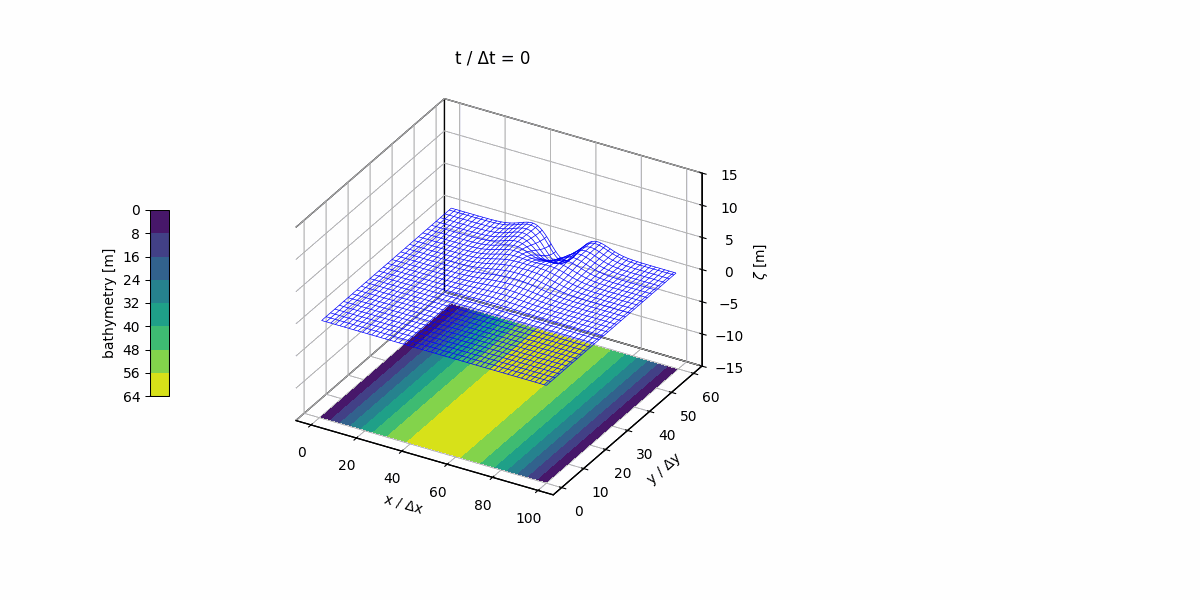

Button(description='Powierzchnia_plynu2D.gif', style=ButtonStyle())

In [ ]:
depth_scale = 60.0   # [m]

def plot(frame, *, zlim=(-.25, .25)):

    psi = output['h'][frame] - bathymetry.copy()

    psi_m = depth_scale * psi
    bathy_m = depth_scale * bathymetry
    zlim_m = (depth_scale * zlim[0], depth_scale * zlim[1])

    xi, yi = np.indices(psi.shape)
    fig, ax = pyplot.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 6))

    ax.plot_wireframe(xi+.5, yi+.5, psi_m, color='blue', linewidth=.5)

    ax.set(
        zlim=zlim_m,
        proj_type='ortho',
        title=f"t / Δt = {frame}",
        zlabel=r"$\zeta$ [m]"
    )

    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor('black')
        axis.pane.set_alpha(1)

    for axis in ('x', 'y'):
        getattr(ax, f'set_{axis}label')(f"{axis} / Δ{axis}")

    cbar = pyplot.colorbar(
        ax.contourf(xi+.5, yi+.5, bathy_m, zdir='z', offset=zlim_m[0]),
        pad=.1, aspect=10, fraction=.02, label='bathymetry [m]', location='left'
    )
    cbar.ax.invert_yaxis()

    return fig

show_anim(plot, range(len(output['h'])), gif_file="Powierzchnia_plynu2D.gif")



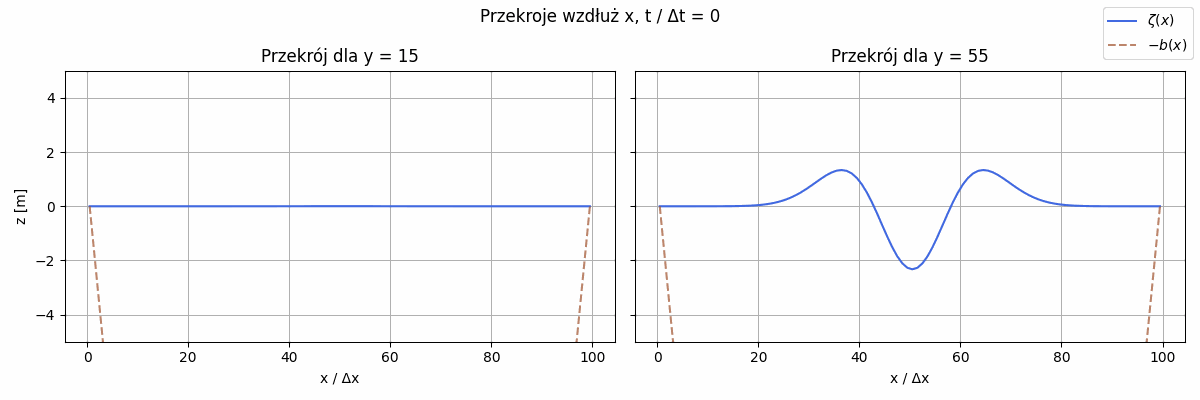

Button(description='Przekroje_y15_y55.gif', style=ButtonStyle())

In [ ]:
depth_scale = 60.0  # [m]

def plot_two_cross_sections(frame, ys=(15, 55)):

    psi = output['h'][frame] - bathymetry.copy()


    psi_m   = depth_scale * psi
    bathy_m = depth_scale * bathymetry

    nx, ny = psi.shape
    x = np.arange(nx) + 0.5

    fig, axes = pyplot.subplots(1, 2, figsize=(12, 4), sharey=True)

    for ax, y_idx in zip(axes, ys):

        zeta_slice   = psi_m[:, y_idx]
        bottom_slice = -bathy_m[:, y_idx]


        ax.plot(x, zeta_slice, label=r'$\zeta(x)$', color='royalblue')

        ax.plot(x, bottom_slice, '--', label=r'$-b(x)$', color='sienna', alpha=0.7)

        ax.set_xlabel('x / Δx')
        ax.grid(True)
        ax.set_title(f'Przekrój dla y = {y_idx}')


    axes[0].set_ylabel('z [m]')

    axes[0].set_ylim(-5,5)


    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    fig.suptitle(f'Przekroje wzdłuż x, t / Δt = {frame}')
    fig.tight_layout()

    return fig


show_anim(plot_two_cross_sections, range(len(output['h'])), gif_file="Przekroje_y15_y55.gif")


In [ ]:
def plot_velocity(frame, eps=1e-7, step=1, arrow_scale=60.0):

    h  = output['h'][frame]
    uh = output['uh'][frame]
    vh = output['vh'][frame]

    nx, ny = h.shape

    u = np.zeros_like(h)
    v = np.zeros_like(h)
    mask = h > eps
    u[mask] = uh[mask] / h[mask]
    v[mask] = vh[mask] / h[mask]

    x = np.arange(nx) + 0.5
    y = np.arange(ny) + 0.5

    X, Y = np.meshgrid(x, y, indexing='ij')

    fig, ax = pyplot.subplots(figsize=(8, 4))

    slx = slice(0, nx, step)
    sly = slice(0, ny, step)

    U_plot = u[slx, sly] * arrow_scale
    V_plot = v[slx, sly] * arrow_scale

    ax.quiver(
        X[slx, sly],
        Y[slx, sly],
        U_plot,
        V_plot,
        angles='xy',
        scale_units='xy',
        scale=1
    )

    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    ax.set_xlabel('x / Δx')
    ax.set_ylabel('y / Δy')
    ax.set_aspect('equal')
    ax.set_title(f"Pole prędkości, t / Δt = {frame}")

    return fig

show_anim(plot_velocity, range(len(output['h'])), gif_file="predkosci_vec.gif")


Output hidden; open in https://colab.research.google.com to view.

### 5. Analiza zbieżności

W celu sprawdzenia, na ile otrzymane rozwiązanie jest poprawne fizycznie i nie dominują w nim efekty numeryczne, powtórzono cały rachunek z dwukrotnie zwiększoną rozdzielczością przestrzenną oraz czasową, a także z dwukrotnie zmniejszoną prędkością dla dwa razy większej ilości kroków czasowych.

In [ ]:
grid = (200, 120)

nx, ny = grid

# DNO
x = np.linspace(0, 1, nx)
v_profile = np.sin(np.pi * x)

bathymetry = np.tile(v_profile[:, None], (1, ny))


# STAN POCZĄTKOWY
h_initial = bathymetry.copy()


x0 = nx // 2
y0 = ny - 1

X, Y = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')


# ZABURZENIE POCZĄTKOWE
rx = nx / 12.0
ry = ny / 6.0

r2 = ((X - x0) / rx)**2 + ((Y - y0) / ry)**2   # r^2
# 2D Mexican hat (Ricker):
mexican_hat = (2.0 / (np.sqrt(3.0) * np.pi**0.25)) * (1.0 - r2) * np.exp(-0.5 * r2)

# (opcjonalnie) normalizacja, żeby max(|ψ|)=1
mexican_hat /= np.max(np.abs(mexican_hat))
amplitude = 0.05
h_initial -= amplitude * mexican_hat


# ROZWIĄZANIE RÓWNAŃ PŁASKIEJ WODY
output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial,
    bathymetry=bathymetry
)(
    nt=800,
    g=10,
    dt_over_dxy=(0.05, 0.05),
    outfreq=12
)


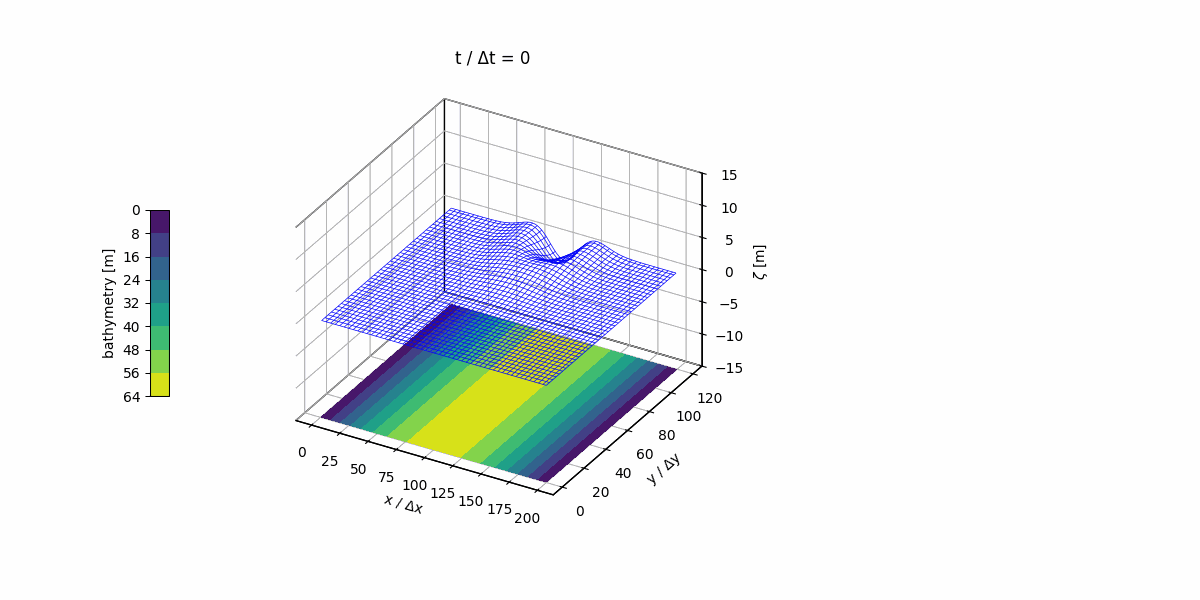

Button(description='Zbieznosc1.gif', style=ButtonStyle())

In [ ]:
depth_scale = 60.0   # [m]

def plot(frame, *, zlim=(-.25, .25)):

    psi = output['h'][frame] - bathymetry.copy()

    psi_m = depth_scale * psi
    bathy_m = depth_scale * bathymetry
    zlim_m = (depth_scale * zlim[0], depth_scale * zlim[1])

    xi, yi = np.indices(psi.shape)
    fig, ax = pyplot.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 6))

    ax.plot_wireframe(xi+.5, yi+.5, psi_m, color='blue', linewidth=.5)

    ax.set(
        zlim=zlim_m,
        proj_type='ortho',
        title=f"t / Δt = {frame}",
        zlabel=r"$\zeta$ [m]"
    )

    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor('black')
        axis.pane.set_alpha(1)

    for axis in ('x', 'y'):
        getattr(ax, f'set_{axis}label')(f"{axis} / Δ{axis}")

    cbar = pyplot.colorbar(
        ax.contourf(xi+.5, yi+.5, bathy_m, zdir='z', offset=zlim_m[0]),
        pad=.1, aspect=10, fraction=.02, label='bathymetry [m]', location='left'
    )
    cbar.ax.invert_yaxis()

    return fig

show_anim(plot, range(len(output['h'])), gif_file="Zbieznosc1.gif")


In [ ]:
grid = (100, 60)

nx, ny = grid

# DNO
x = np.linspace(0, 1, nx)
v_profile = np.sin(np.pi * x)

bathymetry = np.tile(v_profile[:, None], (1, ny))


# STAN POCZĄTKOWY
h_initial = bathymetry.copy()


x0 = nx // 2
y0 = ny - 1

X, Y = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')


# ZABURZENIE POCZĄTKOWE
rx = nx / 12.0
ry = ny / 6.0

r2 = ((X - x0) / rx)**2 + ((Y - y0) / ry)**2   # r^2
# 2D Mexican hat (Ricker):
mexican_hat = (2.0 / (np.sqrt(3.0) * np.pi**0.25)) * (1.0 - r2) * np.exp(-0.5 * r2)

# (opcjonalnie) normalizacja, żeby max(|ψ|)=1
mexican_hat /= np.max(np.abs(mexican_hat))
amplitude = 0.05
h_initial -= amplitude * mexican_hat


# ROZWIĄZANIE RÓWNAŃ PŁASKIEJ WODY
output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial,
    bathymetry=bathymetry
)(
    nt=800,
    g=10,
    dt_over_dxy=(0.025, 0.025),
    outfreq=12
)


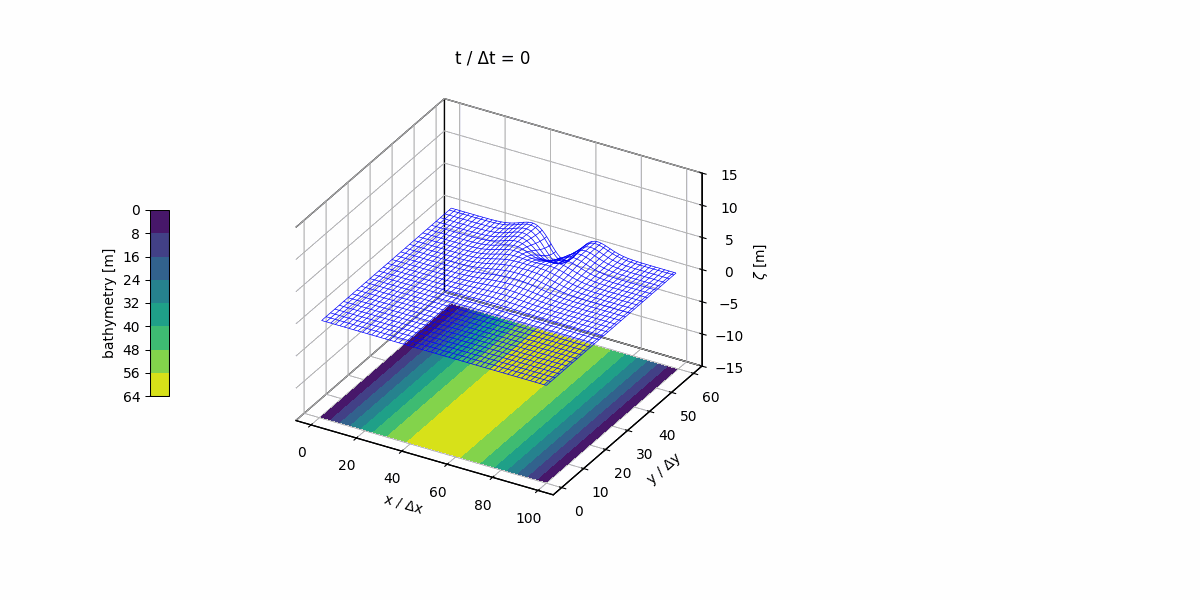

Button(description='Zbieznosc2.gif', style=ButtonStyle())

In [ ]:
depth_scale = 60.0   # [m]

def plot(frame, *, zlim=(-.25, .25)):

    psi = output['h'][frame] - bathymetry.copy()

    psi_m = depth_scale * psi
    bathy_m = depth_scale * bathymetry
    zlim_m = (depth_scale * zlim[0], depth_scale * zlim[1])

    xi, yi = np.indices(psi.shape)
    fig, ax = pyplot.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 6))

    ax.plot_wireframe(xi+.5, yi+.5, psi_m, color='blue', linewidth=.5)

    ax.set(
        zlim=zlim_m,
        proj_type='ortho',
        title=f"t / Δt = {frame}",
        zlabel=r"$\zeta$ [m]"
    )

    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor('black')
        axis.pane.set_alpha(1)

    for axis in ('x', 'y'):
        getattr(ax, f'set_{axis}label')(f"{axis} / Δ{axis}")

    cbar = pyplot.colorbar(
        ax.contourf(xi+.5, yi+.5, bathy_m, zdir='z', offset=zlim_m[0]),
        pad=.1, aspect=10, fraction=.02, label='bathymetry [m]', location='left'
    )
    cbar.ax.invert_yaxis()

    return fig

show_anim(plot, range(len(output['h'])), gif_file="Zbieznosc2.gif")

### 6. Podsumowanie oraz Wnioski

Na podstawie przeprowadzonych symulacji widać wyraźnie, że propagacja fali jest bardziej gwałtowna w tych kierunkach, w których zmniejsza się głębokość dna. Zgadza się to zarówno z intuicją, jak i z wynikami ćwiczeń laboratoryjnych, które pokazywały, że fala dochodząca do brzegu staje się niemal prostym frontem, mimo że początkowo zaburzenie ma charakter punktowy i rozchodzi się radialnie. Na środku jeziora prędkość propagacji fali jest znacznie mniejsza, przez co zaburzenie poziomu wody w tej strefie jest również słabsze. Widać to doskonale na wykresach prędkości propagacji, gdzie wizualizowane strzałki są tożsame z optymalnym ustawieniem kajaka (tak jak zaznaczono w założeniach).

Dla rozważanego scenariusza oznacza to, że w momencie spadku odłamka lodowca do wody najbezpieczniej jest znajdować się w okolicach środka jeziora w dalekiej odległości od ściany lodowca, ustawionym kajakiem równolegle do brzegu. Jeżeli natomiast przebywamy bliżej brzegu, należy starać się ustawić kajak możliwie prostopadle do linii brzegowej, pamiętając jednak, że właśnie w pobliżu brzegów zaburzenie jest najsilniejsze. W analizowanej sytuacji nie przewidziano także  scenariusza "podmywania" brzegu, w związku z czym należy brać pod uwagę że powstała fala po dojściu do brzegu nie odbije się od niego całkowicie. Nie zmienia to jednak rozważań na temat sposobu samego dotarcia fali do brzegu oraz jej rozchodzenia się na przestrzeni środa jeziora.

Odpowiedź na pytanie „Jak bezpiecznie pływać kajakiem po jeziorze polodowcowym?” sprowadza się zatem do dwóch zasad: po pierwsze, trzymać się możliwie daleko od brzegu (co na pierwszy rzut oka może wydawać się nieintuicyjne) oraz od ściany lodowca, a po drugie, ustawiać dziób w kierunku nadchodzącej fali – co w rozważonym przypadku oznacza ustawienie równoległe do brzegu w rejonie środka jeziora, natomiast im bliżej brzegu się znajdujemy, tym bardziej prostopadłe do linii brzegowej powinno być ustawienie kajaka.

Wyniki są zgodne dla przypadków z dwukrotnie zwiększoną rozdzielczością czasową oraz przestrzenną oraz zmniejszoną prędkością, co oznacza, że rozwiązanie jest poprawne fizycznie a obserwowane efekty nie mają silnej natury numerycznej.